In [212]:
import numpy as np
import scipy
import csv
import matplotlib.pyplot as plt
from py3gpp import *

In [213]:
# input_file = '/home/chatchamon/workarea/IQ_constellation/iq_python/input/IQDataFile_SPEEDTEST_10MS.csv'
input_file = '/home/chatchamon/workarea/IQ_constellation/iq_python/input/IQDataFile_SPEEDTEST.csv'

with open(input_file, 'r') as f:
    reader = csv.reader(f)
    for _ in range(19):
        next(reader)

    iq_val = []
    for row in reader:
        i_val = float(row[0])
        q_val = float(row[1])
        iq_val.append(complex(i_val,q_val))     # I+jQ
    # waveform_csv = np.array(iq_val)             # should accept all info, don't know when frame (10ms) start
    waveform_csv = np.array(iq_val[57700:])     # for file SPEEDTEST (20ms)
print('len_waveform_csv', len(waveform_csv))

len_waveform_csv 403101


In [214]:
# downsample signal and sampleRate
dec_factor = 8
waveform = scipy.signal.decimate(waveform_csv, dec_factor, ftype='fir')     # decimate = down sample + low pass filter
waveform /= max(waveform.real.max(), waveform.imag.max())                   # scale up max amplitude print(peak_value)to 1
print('len_waveform', len(waveform))                  # should be shorter than waveorm, as only low signal pass

sampleRate = 23.04e6
sampleRateDS = sampleRate // dec_factor     # floor devision, sampleRate down sample 

len_waveform 50388


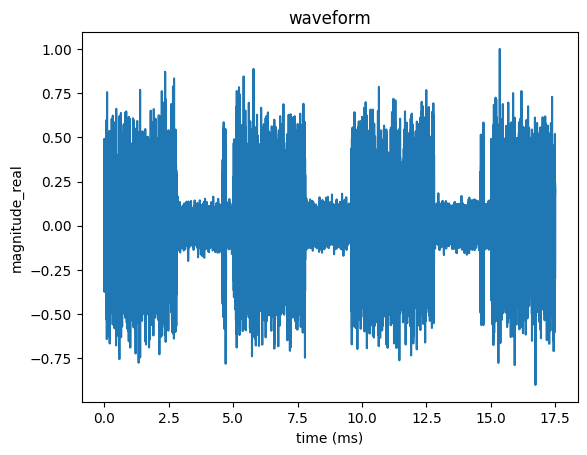

In [215]:
t = np.arange(len(waveform))/sampleRateDS
plt.plot(t*1e3, waveform)
plt.title('waveform') 
plt.xlabel('time (ms)')
plt.ylabel('magnitude_real')
plt.savefig('output_plot/waveform.png')

In [216]:
# add reprodusable SNR to the waveform
np.random.seed(69)
noise = ((np.random.rand(waveform.shape[0]) - 0.5) + 1j*(np.random.rand(waveform.shape[0]) - 0.5)) * 0.8    # -0.5 to be center
SNR = 10*np.log10((np.linalg.norm(waveform) / np.linalg.norm(noise)))
waveform += noise
print(f'SNR = {SNR} dB')

SNR = -1.2763498999306062 dB


In [217]:
# create fshifts to find coarseFrequencyOffset
nrbSSB = 20
scsSSB = 30
searchBW = 6*scsSSB
# searchBW = 12*scsSSB

fshifts = np.arange(-searchBW, searchBW+scsSSB, scsSSB)*1e3/2       # shift by half scs step
# fshifts = np.arange(-searchBW, searchBW+scsSSB, scsSSB)*1e3/5
print('len_fshifts', len(fshifts), 'fshifts:', fshifts)

len_fshifts 13 fshifts: [-90000. -75000. -60000. -45000. -30000. -15000.      0.  15000.  30000.
  45000.  60000.  75000.  90000.]


In [218]:
carrier = nrCarrierConfig(NSizeGrid = nrbSSB, SubcarrierSpacing = scsSSB)
info = nrOFDMInfo(carrier)
Nfft = info['Nfft']         # scs = 30kHz, Nfft = 512
kPSS = np.arange(56, 183)

In [219]:
peak_value = np.zeros((len(fshifts),3))
peak_index = np.zeros((len(fshifts),3), 'int')

for fshifts_index in np.arange(len(fshifts), dtype='int'):
    coarseFrequencyOffset = fshifts[fshifts_index]
    rxWaveformFrquencyShift = waveform*np.exp(-1j*2*np.pi*coarseFrequencyOffset*t)      # shift frequency by coarseFrequencyOffset
    
    nSlot = 0
    T = len(rxWaveformFrquencyShift)

    slotGrid = nrResourceGrid(carrier)
    slotGrid = slotGrid[:,1]

    for current_NID2 in np.arange(3, dtype='int'):
        slotGrid[kPSS] = nrPSS(current_NID2)        # at slot index KPSS assign value nrPSS(current_NID2)
        # generate refWaveform by modulate signal on carrier and slotGrid with assigned nrPSS, then get rid of cyclicPrefix
        [refWaveform, info] = nrOFDMModulate(carrier, slotGrid, scsSSB, nSlot, Nfft, SampleRate=sampleRateDS)
        refWaveform = refWaveform[info['CyclicPrefixLengths'][0]:]; # remove CP

        temp = scipy.signal.correlate(rxWaveformFrquencyShift, refWaveform)     # cross correlate waveform & refWaveform
        t_corr = np.arange(temp.shape[0])/sampleRateDS*1e3

        peak_index[fshifts_index, current_NID2] = np.argmax(np.abs(temp))
        peak_value[fshifts_index, current_NID2] = np.abs(temp[peak_index[fshifts_index, current_NID2]])

In [220]:
max_corr = np.max(peak_value)
select_row = np.floor(np.argmax(peak_value) // 3)   
coarseFrequencyOffset = fshifts[select_row]    
NID2 = np.argmax(peak_value[select_row,:])

print("max_corr", max_corr)
print("coarseFrequencyOffset", coarseFrequencyOffset, "NID2", NID2)

if max_corr < 1.8:                  # choose the threshold randomly
    print("too low correlation")

max_corr 2.113879063943505
coarseFrequencyOffset 0.0 NID2 1


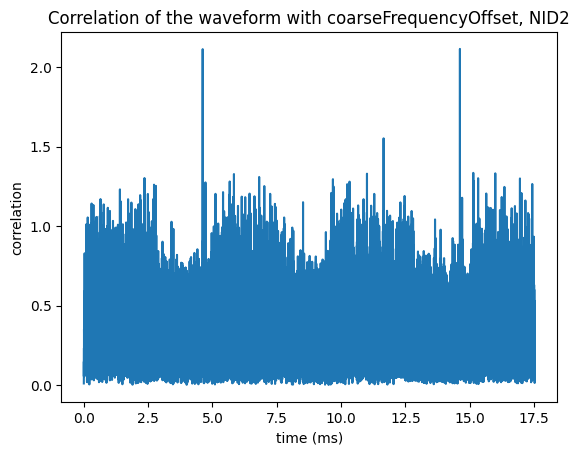

In [221]:
# plot a figure of waveform with selected coarseFrequencyOffset and NID2
rxWaveformFrquencyCorrect = waveform*np.exp(-1j*2*np.pi*coarseFrequencyOffset*t)
slotGrid[kPSS] = nrPSS(NID2)        
[refWaveform, info] = nrOFDMModulate(carrier, slotGrid, scsSSB, nSlot, Nfft, SampleRate=sampleRateDS)
refWaveform = refWaveform[info['CyclicPrefixLengths'][0]:]; # remove CP
temp = scipy.signal.correlate(rxWaveformFrquencyCorrect, refWaveform)
t_corr = np.arange(temp.shape[0])/sampleRateDS*1e3
plt.plot(t_corr, np.abs(temp))
plt.title('Correlation of the waveform with coarseFrequencyOffset, NID2') 
plt.xlabel('time (ms)')
plt.ylabel('correlation')
plt.savefig('output_plot/max_corr.png')


In [223]:
# print(peak_value)

[[1.53088612 1.40514574 1.58632284]
 [1.48491386 1.36425585 1.60582901]
 [1.39374341 1.59119917 1.48516222]
 [1.4881561  1.44450174 1.41528577]
 [1.56848676 1.60453905 1.51866338]
 [1.48966897 1.45345324 1.45856708]
 [1.42966378 2.11387906 1.53334895]
 [1.60898728 1.58497417 1.76376532]
 [1.62853015 1.44595823 1.5741817 ]
 [1.40609913 1.31642889 1.46293929]
 [1.38334652 1.57091598 1.43438963]
 [1.49146312 1.49872429 1.48244793]
 [1.40805003 1.49905548 1.48928632]]
